In [89]:
import numpy as np
import pandas as pd
from pandas import Series
from pymsm.multi_state_competing_risks_model import PathObject, MultiStateModel
from pymsm.datasets import prep_ebmt_long
from pymsm.plotting import stackplot


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The EMBT dataset  
Data from the European Society for Blood and Marrow Transplantation (EBMT)  
  
  
A data frame of 2279 patients transplanted at the EBMT between 1985 and 1998. These data were used in Fiocco, Putter & van Houwelingen (2008), van Houwelingen & Putter (2008, 2012) and de Wreede, Fiocco & Putter (2011). The included variables are  
  
(from R mstate package, see: https://www.rdocumentation.org/packages/mstate/versions/0.3.1/topics/EBMT%20data)  


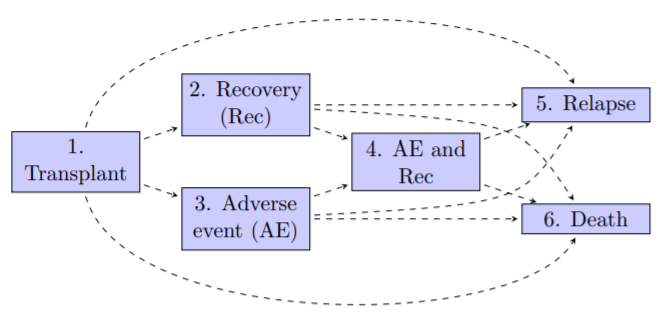

In [90]:
from IPython.display import Image
Image(filename="embt_states.png")

In [91]:
competing_risk_dataset, covariate_cols, states_labels = prep_ebmt_long()
competing_risk_dataset.head()

,sample_id,origin_state,target_state,time_entry_to_origin,time_transition_to_target,match_no gender mismatch,proph_yes,year_1990-1994,year_1995-1998,agecl_<=20,agecl_>40
0,1,1,2,0.0,22.0,1,0,0,1,0,0
1,1,2,0,22.0,995.0,1,0,0,1,0,0
2,2,1,3,0.0,12.0,1,0,0,1,0,0
3,2,3,4,12.0,29.0,1,0,0,1,0,0
4,2,4,5,29.0,422.0,1,0,0,1,0,0


# Peak at some transitions

/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


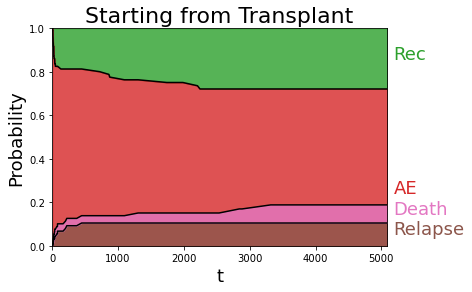

In [102]:
origin_state = 1
stackplot_data = competing_risk_dataset[
    competing_risk_dataset["origin_state"] == origin_state
].sample(100)

stackplot(
    data=stackplot_data,
    origin_state=origin_state,
    duration_col="time_transition_to_target",
    event_col="target_state",
    order_top=[2, 3],
    order_bottom=[5, 6],
    labels=states_labels,
)

/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


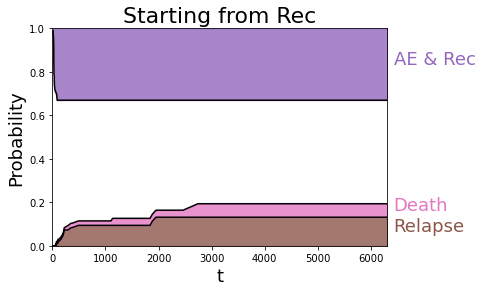

In [103]:
origin_state = 2
stackplot_data = competing_risk_dataset[
    competing_risk_dataset["origin_state"] == origin_state
].sample(100)

stackplot(
    data=stackplot_data,
    origin_state=origin_state,
    duration_col="time_transition_to_target",
    event_col="target_state",
    order_top=[4],
    order_bottom=[5, 6],
    labels=states_labels,
)

# Fit MSM

In [95]:
def default_update_covariates_function(
    covariates_entering_origin_state,
    origin_state=None,
    target_state=None,
    time_at_origin=None,
    abs_time_entry_to_target_state=None,
):
    return covariates_entering_origin_state


terminal_states = [5, 6]


multi_state_model = MultiStateModel(
    competing_risk_dataset,
    terminal_states,
    default_update_covariates_function,
    covariate_cols,
    competing_risk_data_format=True,
)


multi_state_model.fit()


Fitting Model at State: 1
>>> Fitting Transition to State: 2, n events: 785
>>> Fitting Transition to State: 3, n events: 907
>>> Fitting Transition to State: 5, n events: 95
>>> Fitting Transition to State: 6, n events: 160
Fitting Model at State: 2
>>> Fitting Transition to State: 5, n events: 112
>>> Fitting Transition to State: 6, n events: 39
>>> Fitting Transition to State: 4, n events: 227
Fitting Model at State: 3
>>> Fitting Transition to State: 4, n events: 433
>>> Fitting Transition to State: 6, n events: 197
>>> Fitting Transition to State: 5, n events: 56
Fitting Model at State: 4
>>> Fitting Transition to State: 5, n events: 107
>>> Fitting Transition to State: 6, n events: 137


# Single patient statistics

In [96]:
# Run MC for a sample single patient
mc_paths = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=competing_risk_dataset.loc[0,covariate_cols],
    origin_state=1,
    current_time=0,
    n_random_samples=4,
    max_transitions=5,
)

# print paths
for mc_path in mc_paths:
    states = mc_path.states
    time_at_each_state = mc_path.time_at_each_state
    print(states)
    print(time_at_each_state)

    num_nonterminal_states = len(time_at_each_state)
    nonterminal_states = states[:num_nonterminal_states]
    # print(nonterminal_states)


[1, 2, 4, 6]
[19.000075513725566, 14.999938494675956, 140.0000829825837]
[1, 3, 4, 6]
[10.000023167170138, 229.99997683282987, 3382.000080839735]
[1, 3, 4, 6]
[20.00008129857387, 19.999956128505705, 677.9999625729204]
[1, 2, 4, 6]
[34.00008530094555, 0.9999667058565649, 2183.999947993198]


In [112]:
from pymsm.statistics import prob_visited_states

all_states = competing_risk_dataset["target_state"].unique()
# Probability of visiting any of the states
for state in all_states:
    if state==0:
        continue
    print(f"Probabilty of {states_labels[state]} = {prob_visited_states(mc_paths, states=[state])}")

# Probability of terminal states - Death and Relapse
print(f"Probabilty of any terminal state = {prob_visited_states(mc_paths, states=multi_state_model.terminal_states)}")   

Probabilty of Rec = 0.5
Probabilty of AE = 0.5
Probabilty of AE & Rec = 1.0
Probabilty of Relapse = 0.0
Probabilty of Death = 1.0
Probabilty of any terminal state = 1.0


In [68]:
# from pymsm.multi_state_competing_risks_model import PathObject
# from typing import List


# def prob_visited_states(paths: List[PathObject], states: List):
#     states = set(states)
#     return np.mean([len(states.intersection(set(path.states)))>0 for path in paths])
